In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn import neighbors

In [2]:
def scaleMatrix(matrix):
    return matrix.div(matrix.sum(axis=1),axis=0)

In [3]:
def norm(series):
    b = max(series)
    a = min(series)
    return [(x - a) / (b - a) for x in series]

In [4]:
def npmc(init_state, matrix, original_states, init_state_col):
    matrix = scaleMatrix(matrix)
    probs = {k:list(matrix.iloc[original_states.index(k)]) for k in original_states}
    NewState = []
    for x in range(len(init_state)):
        NewState.append(np.random.choice(a = matrix.columns, p = probs[init_state[init_state_col][x]],size=1)[0])
    NextStep = pd.DataFrame()
    NextStep["Original State"] = init_state[init_state_col]
    NextStep["New State"] = NewState
    return NextStep

In [5]:
def multinpmc(init_state, matrix, original_states, init_state_col,n):
    init_state = init_state.copy()
    out = pd.DataFrame()
    out["Original State"] = init_state[init_state_col]
    for i in range(n):
        out[i] = npmc(init_state,matrix,original_states,init_state_col)["New State"]
    return out

In [91]:
def chain(init_state, matrix, original_states, init_state_col,n):
    init_state = init_state.copy()
    out = pd.DataFrame()
    out[0] = init_state[init_state_col]
    for i in range(1,n+1):
        out[i] = npmc(out,matrix,original_states,i-1)["New State"]
    return out

In [6]:
%%time
n = 100
pop = pd.DataFrame()
bmi = []
age = []
s1 = []
s2 = []
to_color_plot = []
ageMean = 39.5
ageSD = 16.5
bmiMean = 26.5
bmiSD = 5.5
for i in range(n):
    bmi.append(st.norm.rvs(bmiMean,bmiSD))
    age.append(st.norm.rvs(ageMean,ageSD))
    u = st.uniform.rvs()
    q = st.uniform.rvs()
    if bmi[-1] > 35 and age[-1] > 60:
        if u < 0.2:
            s1.append("H")
            if q < 0.5:
                s2.append("H")
                to_color_plot.append(1)
            elif q < 0.9:
                s2.append("S")
                to_color_plot.append(2)
            else:
                s2.append("D")
                to_color_plot.append(3)
        elif u < 0.8:
            s1.append("S")
            if q < 0.2:
                s2.append("H")
                to_color_plot.append(1)
            elif q < 0.85:
                s2.append("S")
                to_color_plot.append(2)
            else:
                s2.append("D")
                to_color_plot.append(3)
        else:
            s1.append("D")
            s2.append("D")
            to_color_plot.append(3)
    elif bmi[-1] > 30 and age[-1] > 30:
            if u < 0.5:
                s1.append("H")
                if q < 0.75:
                    s2.append("H")
                    to_color_plot.append(1)
                elif q < 0.95:
                    s2.append("S")
                    to_color_plot.append(2)
                else:
                    s2.append("D")
                    to_color_plot.append(3)
            elif u < 0.9:
                s1.append("S")
                if q < 0.3:
                    s2.append("H")
                    to_color_plot.append(1)
                elif q < 0.9:
                    s2.append("S")
                    to_color_plot.append(2)
                else:
                    s2.append("D")
                    to_color_plot.append(3)
            else:
                s1.append("D")
                s2.append("D")
                to_color_plot.append(3)
    else:
        if u < 0.65:
            s1.append("H")
            if q < 0.75:
                s2.append("H")
                to_color_plot.append(1)
            elif q < 0.9:
                s2.append("S")
                to_color_plot.append(2)
            else:
                s2.append("D")
                to_color_plot.append(3)
        elif u < 0.9:
            s1.append("S")
            if q < 0.5:
                s2.append("H")
                to_color_plot.append(1)
            elif q < 0.8:
                s2.append("S")
                to_color_plot.append(2)
            else:
                s2.append("D")
                to_color_plot.append(3)
        else:
            s1.append("D")
            s2.append("D")
            to_color_plot.append(3)
pop["BMI"] = bmi
pop["Age"] = age
pop["S0"] = ["H" for i in range(n)]
pop["S1"] = s1
pop["S2"] = s2
pop["Color Code"] = to_color_plot
pop.head()
h1 = pop.loc[pop["S1"] == "H"]
s1 = pop.loc[pop["S1"] == "S"]

CPU times: user 20.8 ms, sys: 3.09 ms, total: 23.9 ms
Wall time: 21.9 ms


In [7]:
print(h1["S2"].value_counts())
print(s1["S2"].value_counts())
pop["Color Code"]

H    46
S    13
D     6
Name: S2, dtype: int64
H    16
S     9
D     4
Name: S2, dtype: int64


0     1
1     1
2     1
3     2
4     1
     ..
95    1
96    1
97    1
98    1
99    1
Name: Color Code, Length: 100, dtype: int64

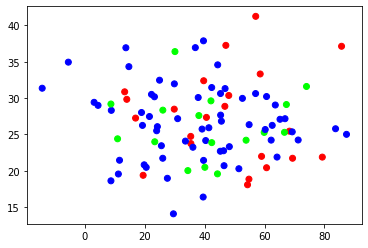

In [8]:
plt.scatter(pop["Age"],pop["BMI"], c = pop["Color Code"],cmap = "brg")
plt.show()

In [9]:
## H1
n_neighbors = 30
scale = pd.DataFrame()
scale["BMI"] = norm(h1["BMI"])
scale["Age"] = norm(h1["Age"])
healthyknn = neighbors.KNeighborsClassifier(n_neighbors)
X = scale[["BMI","Age"]]
y = h1["Color Code"]
healthyknn.fit(X,y)

KNeighborsClassifier(n_neighbors=30)

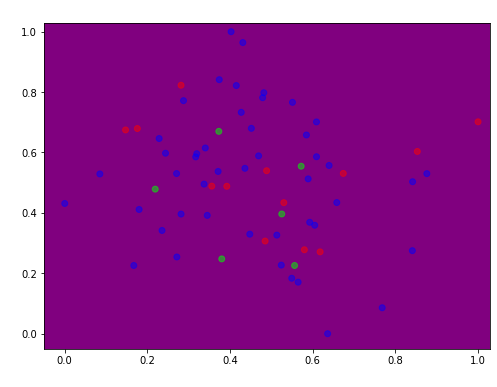

In [10]:
h = 0.02
x_min, x_max = X["BMI"].min(), X["BMI"].max()
y_min, y_max = X["Age"].min(), X["Age"].max()
xx, yy = np.meshgrid(np.arange(x_min-.05, x_max+.05, h), np.arange(y_min-.05, y_max+.05, h))
Z = healthyknn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap="brg")
plt.scatter(X["BMI"],X["Age"], cmap = "brg", c = y,alpha = 0.5)
plt.title("Class based on BMI and Age", c = "white", loc="left")
plt.xlabel("BMI", c = "white")
plt.ylabel("Age", c = "white")
plt.show()

In [18]:
## S1
n_neighbors = 10
scale = pd.DataFrame()
scale["BMI"] = norm(s1["BMI"])
scale["Age"] = norm(s1["Age"])
sickknn = neighbors.KNeighborsClassifier(n_neighbors)
X = scale[["BMI","Age"]]
y = s1["Color Code"]
sickknn.fit(X,y)

KNeighborsClassifier(n_neighbors=10)

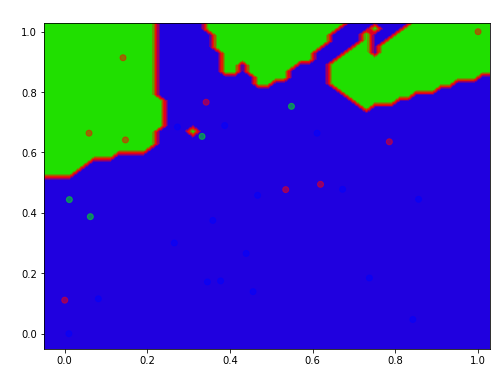

In [19]:
h = 0.02
x_min, x_max = X["BMI"].min(), X["BMI"].max()
y_min, y_max = X["Age"].min(), X["Age"].max()
xx, yy = np.meshgrid(np.arange(x_min-.05, x_max+.05, h), np.arange(y_min-.05, y_max+.05, h))
Z = sickknn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap="brg")
plt.scatter(X["BMI"],X["Age"], cmap = "brg", c = y,alpha = 0.5)
plt.title("Class based on BMI and Age", c = "white", loc="left")
plt.xlabel("BMI", c = "white")
plt.ylabel("Age", c = "white")
plt.show()

In [20]:
healthyknn.kneighbors([[0.5,0.5]],n_neighbors,False)
sickknn.kneighbors([[0.5,0.5]],n_neighbors,False)

array([[25, 23,  0, 24, 15,  8, 16, 18, 11,  3]])

In [21]:
hp = h1["S2"].iloc[healthyknn.kneighbors([[0.5,0.5]],n_neighbors,False)[0]].value_counts(sort=False) / n_neighbors
htmsl = pd.DataFrame()
htmsl["H"] = [hp[0]]
htmsl["S"] = [hp[1]]
htmsl["D"] = [max(0,1-hp[0]-hp[1])]
htmsl

,H,S,D
0,0.2,0.5,0.3


In [22]:
sp = s1["S2"].iloc[sickknn.kneighbors([[0.5,0.5]],n_neighbors,False)[0]].value_counts(sort=False) / n_neighbors
stmsl = pd.DataFrame()
stmsl["H"] = [sp[0]]
stmsl["S"] = [sp[1]]
stmsl["D"] = [max(0,1-hp[0]-hp[1])]
stmsl

,H,S,D
0,0.2,0.6,0.3


In [23]:
n_iter = 10
single_life = pd.DataFrame()
single_life["S0"] = ["H"]
start = ["H"]
h_out = multinpmc(init_state = single_life, matrix = htmsl, original_states = start, init_state_col = "S0",n=n_iter)

In [24]:
single_life = pd.DataFrame()
single_life["S0"] = ["S"]
start = ["S"]
s_out= multinpmc(init_state = single_life, matrix = stmsl, original_states = start, init_state_col = "S0",n=n_iter)

In [25]:
h_out[[x for x in range(n_iter)]].T[0].value_counts()

D    5
S    3
H    2
Name: 0, dtype: int64

In [26]:
s_out[[x for x in range(n_iter)]].T[0].value_counts()

S    4
D    3
H    3
Name: 0, dtype: int64

In [27]:
n_test = 10
test = [(st.norm.rvs(loc = 0.5,scale = 35/120),st.norm.rvs(loc=0.5, scale = 35/120)) for x in range(n_test)]
test[:5]

[(0.08088494408533364, 0.6278685197550904),
 (0.6689797521693256, -0.0058212550061172985),
 (0.3666019559166447, 0.5254152496333201),
 (0.03080951328298398, 0.41792315133421),
 (0.28859255922750526, 0.34321280823737055)]

In [28]:
hnn = healthyknn.kneighbors([[x[0],x[1]] for x in test],n_neighbors,False)
n_iter = 10
h_out = pd.DataFrame(columns = [i for i in range(n_iter)])
for i in range(n_iter):
    h_out[i] = [0 for i in range(n_test)]
for h in range(n_test):
    hp = h1["S2"].iloc[hnn[h]].value_counts(sort = False) / n_neighbors
    htmsl = pd.DataFrame()
    htmsl["H"] = [hp[0]]
    htmsl["S"] = [hp[1]]
    htmsl["D"] = [max(0,1-hp[0]-hp[1])]
    single_life = pd.DataFrame()
    single_life["S0"] = ["H"]
    start = ["H"]
    h_out.iloc[h] = list(multinpmc(init_state = single_life, matrix = htmsl, original_states = start,init_state_col = "S0",n=n_iter)[[x for x in range(n_iter)]].T[0])

IndexError: index out of bounds

In [29]:
sums = pd.DataFrame()
H = []
D = []
S = []
for i in range(n_iter):
    H.append(h_out[i].value_counts(sort=False)[0])
    D.append(h_out[i].value_counts(sort=False)[1])
    S.append(h_out[i].value_counts(sort=False)[2])
sums["H"] = H
sums["D"] = D
sums["S"] = S
sums = sums.T

KeyError: 1

In [30]:
h_out

,0,1,2,3,4,5,6,7,8,9
0,H,S,S,S,S,S,S,S,S,S
1,S,H,H,D,S,H,S,H,S,H
2,H,H,H,H,H,H,H,H,H,H
3,H,S,S,S,H,S,S,D,H,S
4,S,D,D,D,H,D,D,H,S,S
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [88]:
df = pd.read_csv("CVX.csv")["Adj Close"]
df = df.iloc[::3]
df.reset_index(drop = True,inplace = True)
df = np.sign(df.pct_change()[1:])
np.random.seed(10)
for i in range(1,len(df)):
    if df[i] == 0:
        q = st.bernoulli.rvs(0.5)
        if q == 0:
            df[i] = -1
        else:
            df[i] = 1
states = ["Up","Down"]
TM = pd.DataFrame(index = ["Up","Down"])
tm = {"UU":0,"UD":0,"DU":0,"DD":0}
for i in range(2,len(df)):
    if df[i] == 1 and df[i-1] == 1:
        tm["UU"] += 1
    elif df[i] == -1 and df[i-1] == 1:
        tm["UD"] += 1
    elif df[i] == 1 and df[i-1] == -1:
        tm["DU"] += 1
    else:
        tm["DD"] += 1
TM["Up"] = [tm["UU"],tm["UD"]]
TM["Down"] = [tm["DU"],tm["DD"]]
TM = scaleMatrix(TM)
TM

,Up,Down
Up,0.566667,0.433333
Down,0.634146,0.365854


In [99]:
test = pd.DataFrame()
test["State"] = ["Up"]
chain(test, TM, ["Up","Down"], "State",400).iloc[0][1:].value_counts()

Up      246
Down    154
Name: 0, dtype: int64

In [117]:
tick = pd.read_csv("Tickers.csv")
all_data = {}
all_tm = {}
for x in tick["Ticker"]:
    df = pd.DataFrame()
    df["Return"] = pd.read_csv(x+".csv")["Adj Close"]
    df["Time"] = pd.read_csv(x+".csv")["Date"]
    df = df.iloc[::3]
    df.reset_index(drop = True,inplace = True)
    df["Return"] = np.sign(df["Return"].pct_change()[1:])
    np.random.seed(10)
    for i in range(1,len(df)):
        if df["Return"][i] == 0:
            q = st.bernoulli.rvs(0.5)
            if q == 0:
                df["Return"][i] = -1
            else:
                df["Return"][i] = 1
    states = ["Up","Down"]
    TM = pd.DataFrame(index = ["Up","Down"])
    tm = {"UU":0,"UD":0,"DU":0,"DD":0}
    for i in range(2,len(df)):
        if df["Return"][i] == 1 and df["Return"][i-1] == 1:
            tm["UU"] += 1
        elif df["Return"][i] == -1 and df["Return"][i-1] == 1:
            tm["UD"] += 1
        elif df["Return"][i] == 1 and df["Return"][i-1] == -1:
            tm["DU"] += 1
        else:
            tm["DD"] += 1
    TM["Up"] = [tm["UU"],tm["UD"]]
    TM["Down"] = [tm["DU"],tm["DD"]]
    TM = scaleMatrix(TM)
    all_tm[x] = TM
    all_data[x] = df.iloc[1:]

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [118]:
l = 0
for x in all_data.keys():
    l+= len(all_data[x])
l

3604

In [125]:
all_data["APA"]

,Return,Time
1,1.0,1985-04-01
2,-1.0,1985-07-01
3,1.0,1985-10-01
4,-1.0,1986-01-01
5,-1.0,1986-04-01
...,...,...
142,1.0,2020-07-01
143,-1.0,2020-10-01
144,1.0,2021-01-01
145,1.0,2021-04-01


In [127]:
all_tm["APA"]

,Up,Down
Up,0.511905,0.488095
Down,0.688525,0.311475
